In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
def load_csv_from_github(file_name):
    """
    Load CSV file from GitHub repository
    """
    base_url = "https://raw.githubusercontent.com/marymorkos/SalesPlaybookDS5640/refs/heads/main/"
    return pd.read_csv(base_url + file_name)

# Load the data
deals_df = load_csv_from_github("anonymized_hubspot_deals.csv")

# Create a copy for cleaning
df_clean = deals_df.copy()

In [3]:

# 1. COLUMN STANDARDIZATION
# -------------------------------
# Standardize column names
df_clean.columns = [col.strip().lower().replace(' ', '_').replace('"', '').replace('(', '').replace(')', '') 
                  for col in df_clean.columns]

# 2. HANDLE MISSING VALUES
# -------------------------------
# Remove rows that are completely empty
empty_rows_count = df_clean.isna().all(axis=1).sum()
df_clean.dropna(how='all', inplace=True)
print(f"Removed {empty_rows_count} completely empty rows")

# Identify columns with excessive missing values (>90%)
missing_percentages = df_clean.isnull().mean() * 100
high_missing_cols = missing_percentages[missing_percentages > 90].index.tolist()
print(f"Identified {len(high_missing_cols)} columns with >90% missing values")

#Drop columns with high missing values
print("Dropped columns:", high_missing_cols)
#df_clean.drop(columns=high_missing_cols, inplace=True)
df_clean


Removed 0 completely empty rows
Identified 15 columns with >90% missing values
Dropped columns: ['cumulative_time_in_opportunity_sales_pipeline_hh:mm:ss', 'cumulative_time_in_in_trial_-_trial_in_progress_sales_pipeline_hh:mm:ss', 'cumulative_time_in_partner_referrals__sales_pipeline_hh:mm:ss', 'cumulative_time_in_closed_lost_sales_pipeline_hh:mm:ss', 'cumulative_time_in_deep_dive._psp_drafted_sales_pipeline_hh:mm:ss', 'annual_contract_value', 'annual_recurring_revenue', 'monthly_recurring_revenue', 'forecast_probability', 'trial_start_date', 'trial_end_date', 'cumulative_time_in_closed_trial_sales_pipeline_hh:mm:ss', 'cumulative_time_in_renewals__sales_pipeline_hh:mm:ss', 'total_contract_value', 'cumulative_time_in_closed_won_sales_pipeline_hh:mm:ss']


,weighted_amount,deal_description,cumulative_time_in_bant_deal._pain_id'ed_sales_pipeline_hh:mm:ss,cumulative_time_in_opportunity_sales_pipeline_hh:mm:ss,days_to_close,deal_score,close_date,deal_source_attribution_2,cumulative_time_in_in_trial_-_trial_in_progress_sales_pipeline_hh:mm:ss,contract_start_date,...,cumulative_time_in_negotiation_sales_pipeline_hh:mm:ss,is_open_numeric,cumulative_time_in_renewals__sales_pipeline_hh:mm:ss,create_date,cumulative_time_in_contract_sent_sales_pipeline_hh:mm:ss,total_contract_value,last_modified_date,cumulative_time_in_closed_won_sales_pipeline_hh:mm:ss,deal_stage,deal_type
0,250.0,40-50 employees,NaN,NaN,69.0,33.0,2025-05-01 15:26,Event,NaN,NaN,...,NaN,1.0,NaN,2025-02-20 15:27,NaN,NaN,2025-02-20 16:28,NaN,Opportunity,New
1,0.0,"3,000 + Agents.",NaN,NaN,149.0,13.0,2025-07-20 09:06,Referral Partner,NaN,NaN,...,NaN,1.0,NaN,2025-02-20 08:07,NaN,NaN,2025-02-20 09:08,NaN,Partner Referrals,New
2,0.0,5-6k agents,NaN,NaN,149.0,13.0,2025-07-20 09:03,Referral Partner,NaN,NaN,...,NaN,1.0,NaN,2025-02-20 08:04,NaN,NaN,2025-02-20 09:05,NaN,Partner Referrals,New
3,0.0,Furthest Along - 300 agents,NaN,NaN,149.0,13.0,2025-07-20 08:55,Referral Partner,NaN,NaN,...,NaN,1.0,NaN,2025-02-20 07:58,NaN,NaN,2025-02-20 08:59,NaN,Partner Referrals,New
4,10000.0,BPO through partnership with AmplifAI,NaN,NaN,120.0,37.0,2025-06-20 15:01,Master Agent,NaN,NaN,...,NaN,1.0,NaN,2025-02-19 14:02,NaN,NaN,2025-02-19 15:03,NaN,Deep Dive. PSP Drafted,New
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,78000.0,Development of training Syms for the transitio...,NaN,NaN,131.0,NaN,2022-12-20 11:59,SymTrain EE name,NaN,2020-03-13,...,NaN,0.0,NaN,2022-08-10 16:48,NaN,NaN,2025-02-20 11:21,NaN,Closed Won,New
589,216600.0,NaN,NaN,NaN,131.0,NaN,2022-12-20 11:59,SymTrain EE name,NaN,2020-09-01,...,NaN,0.0,NaN,2022-08-10 14:49,NaN,NaN,2025-02-20 11:21,NaN,Closed Won,New
590,34200.0,New project with Retail Services. Citi L&D gr...,NaN,NaN,131.0,NaN,2022-12-20 11:59,SymTrain EE name,NaN,2021-01-15,...,NaN,0.0,NaN,2022-08-10 14:49,NaN,NaN,2025-02-20 11:21,NaN,Closed Won,New
591,53240.0,Seasonal Hurricane Support for New Hires,2044:36:26,NaN,246.0,NaN,2023-04-13 12:59,Referral Partner,NaN,NaN,...,242:06:06,0.0,NaN,2022-08-09 17:32,336:18:05,NaN,2025-02-19 10:45,NaN,Closed Won,New


In [4]:
# Keep only the truly unnecessary columns (e.g., trial dates, closed_lost time)
columns_to_drop = [
    'trial_start_date',
    'trial_end_date',
    'cumulative_time_in_closed_trial_sales_pipeline_hh:mm:ss',
    'cumulative_time_in_closed_lost_sales_pipeline_hh:mm:ss',
    'cumulative_time_in_partner_referrals__sales_pipeline_hh:mm:ss'
]

df_clean.drop(columns=columns_to_drop, inplace=True)


In [5]:
# 3. DATA TYPE CONVERSIONS
# -------------------------------
# Convert string booleans to actual booleans
boolean_columns = ['is_closed_won', 'is_closed_lost', 'is_deal_closed']
for col in boolean_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).str.lower() == 'true'

# Convert date columns to datetime
date_columns = ['close_date', 'create_date', 'last_activity_date', 'last_modified_date',
               'contract_start_date', 'contract_end_date', 'trial_start_date', 'trial_end_date']

for col in date_columns:
    if col in df_clean.columns:
        # Count non-null values before conversion
        non_null_before = df_clean[col].notna().sum()
        
        # Convert to datetime
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')
        
        # Count non-null values after conversion
        non_null_after = df_clean[col].notna().sum()
        
        print(f"{col}: {non_null_before} non-null values before, {non_null_after} after conversion")


close_date: 543 non-null values before, 543 after conversion
create_date: 593 non-null values before, 593 after conversion
last_activity_date: 402 non-null values before, 402 after conversion
last_modified_date: 593 non-null values before, 593 after conversion
contract_start_date: 69 non-null values before, 69 after conversion
contract_end_date: 71 non-null values before, 71 after conversion


In [6]:
# 4. TEXT FIELD CLEANING
# -------------------------------
# Remove leading/trailing whitespace from text fields
text_columns = ['deal_description', 'deal_name', 'associated_company', 'deal_owner', 
                'associated_company_primary']

for col in text_columns:
    if col in df_clean.columns:
        # Count values with leading/trailing whitespace
        whitespace_before = sum(df_clean[col].astype(str).str.strip() != df_clean[col].astype(str))
        
        # Clean whitespace
        df_clean[col] = df_clean[col].astype(str).str.strip()
        
        # Report count
        if whitespace_before > 0:
            print(f"Cleaned {whitespace_before} values with whitespace in {col}")


Cleaned 8 values with whitespace in deal_description


In [7]:

# 5. FIX DATA INCONSISTENCIES
# -------------------------------
# Check for stage-status inconsistencies
if all(col in df_clean.columns for col in ['deal_stage', 'is_closed_won', 'is_closed_lost']):
    stage_status_mismatches = df_clean[
        ((df_clean['deal_stage'] == 'Closed Won') & (df_clean['is_closed_won'] != True)) |
        ((df_clean['deal_stage'] == 'Closed Lost') & (df_clean['is_closed_lost'] != True)) |
        ((~df_clean['deal_stage'].isin(['Closed Won', 'Closed Lost'])) & 
         ((df_clean['is_closed_won'] == True) | (df_clean['is_closed_lost'] == True)))
    ]

    print(f"Found {len(stage_status_mismatches)} stage-status mismatches")

    # Count how many you're about to fix
    won_fixed = ((df_clean['deal_stage'] == 'Closed Won') & (df_clean['is_closed_won'] != True)).sum()
    lost_fixed = ((df_clean['deal_stage'] == 'Closed Lost') & (df_clean['is_closed_lost'] != True)).sum()

    print("Fixing inconsistencies using deal_stage as the source of truth:")
    print(f"- Updating {won_fixed} records to is_closed_won = True")
    print(f"- Updating {lost_fixed} records to is_closed_lost = True")

    # Apply the fixes
    df_clean.loc[df_clean['deal_stage'] == 'Closed Won', 'is_closed_won'] = True
    df_clean.loc[df_clean['deal_stage'] == 'Closed Lost', 'is_closed_lost'] = True



Found 0 stage-status mismatches
Fixing inconsistencies using deal_stage as the source of truth:
- Updating 0 records to is_closed_won = True
- Updating 0 records to is_closed_lost = True


In [57]:
df_clean[df_clean['deal_stage'] == 'Closed Won'][['is_closed_won', 'is_won']].value_counts()


is_closed_won  is_won
True           True      158
Name: count, dtype: int64

In [8]:
# 6. CREATE DERIVED FIELDS
# -------------------------------
# Convert create_date to datetime if not already
df_clean['create_date'] = pd.to_datetime(df_clean['create_date'], errors='coerce')

# Add deal size categories
def categorize_deal_size(amount):
    if pd.isna(amount):
        return "Unknown"
    elif amount < 10000:
        return "Small (< $10K)"
    elif amount < 50000:
        return "Medium ($10K-$50K)"
    elif amount < 100000:
        return "Large ($50K-$100K)"
    else:
        return "Enterprise (>= $100K)"

if 'amount' in df_clean.columns:
    df_clean['deal_size_category'] = df_clean['amount'].apply(categorize_deal_size)

# Add sales cycle categories
def categorize_sales_cycle(days):
    if pd.isna(days):
        return "Unknown"
    elif days < 30:
        return "Very Short (<30 days)"
    elif days < 90:
        return "Short (30-89 days)"
    elif days < 180:
        return "Medium (90-179 days)"
    elif days < 365:
        return "Long (180-364 days)"
    else:
        return "Very Long (365+ days)"

if 'days_to_close' in df_clean.columns:
    df_clean['sales_cycle_category'] = df_clean['days_to_close'].apply(categorize_sales_cycle)

# Create time-based fields
if 'create_date' in df_clean.columns:
    df_clean['create_year'] = df_clean['create_date'].dt.year
    df_clean['create_month'] = df_clean['create_date'].dt.month
    df_clean['create_year_month'] = df_clean['create_date'].dt.strftime('%Y-%m')


In [9]:
df_clean.head()

,weighted_amount,deal_description,cumulative_time_in_bant_deal._pain_id'ed_sales_pipeline_hh:mm:ss,cumulative_time_in_opportunity_sales_pipeline_hh:mm:ss,days_to_close,deal_score,close_date,deal_source_attribution_2,cumulative_time_in_in_trial_-_trial_in_progress_sales_pipeline_hh:mm:ss,contract_start_date,...,total_contract_value,last_modified_date,cumulative_time_in_closed_won_sales_pipeline_hh:mm:ss,deal_stage,deal_type,deal_size_category,sales_cycle_category,create_year,create_month,create_year_month
0,250.0,40-50 employees,NaN,NaN,69.0,33.0,2025-05-01 15:26:00,Event,NaN,NaT,...,NaN,2025-02-20 16:28:00,NaN,Opportunity,New,Small (< $10K),Short (30-89 days),2025,2,2025-02
1,0.0,"3,000 + Agents.",NaN,NaN,149.0,13.0,2025-07-20 09:06:00,Referral Partner,NaN,NaT,...,NaN,2025-02-20 09:08:00,NaN,Partner Referrals,New,Small (< $10K),Medium (90-179 days),2025,2,2025-02
2,0.0,5-6k agents,NaN,NaN,149.0,13.0,2025-07-20 09:03:00,Referral Partner,NaN,NaT,...,NaN,2025-02-20 09:05:00,NaN,Partner Referrals,New,Small (< $10K),Medium (90-179 days),2025,2,2025-02
3,0.0,Furthest Along - 300 agents,NaN,NaN,149.0,13.0,2025-07-20 08:55:00,Referral Partner,NaN,NaT,...,NaN,2025-02-20 08:59:00,NaN,Partner Referrals,New,Small (< $10K),Medium (90-179 days),2025,2,2025-02
4,10000.0,BPO through partnership with AmplifAI,NaN,NaN,120.0,37.0,2025-06-20 15:01:00,Master Agent,NaN,NaT,...,NaN,2025-02-19 15:03:00,NaN,Deep Dive. PSP Drafted,New,Large ($50K-$100K),Medium (90-179 days),2025,2,2025-02


In [10]:
duplicates = df_clean.duplicated(subset='record_id').sum()
print(f"Duplicate record_id rows: {duplicates}")


Duplicate record_id rows: 0


In [11]:
missing = df_clean.isna().sum()
missing[missing > 0].sort_values(ascending=False)


forecast_probability                                                       593
monthly_recurring_revenue                                                  592
annual_contract_value                                                      592
total_contract_value                                                       592
annual_recurring_revenue                                                   592
cumulative_time_in_closed_won_sales_pipeline_hh:mm:ss                      580
cumulative_time_in_opportunity_sales_pipeline_hh:mm:ss                     556
cumulative_time_in_renewals__sales_pipeline_hh:mm:ss                       554
cumulative_time_in_deep_dive._psp_drafted_sales_pipeline_hh:mm:ss          551
cumulative_time_in_in_trial_-_trial_in_progress_sales_pipeline_hh:mm:ss    549
contract_term_months                                                       524
contract_start_date                                                        524
contract_end_date                                   

In [12]:
df_clean['original_traffic_source'] = df_clean['original_traffic_source'].fillna('Unknown')
df_clean['deal_source_attribution_2'] = df_clean['deal_source_attribution_2'].fillna('Unknown')

In [13]:
for col in ['weighted_amount', 'amount_in_company_currency', 'weighted_amount_in_company_currency']:
    df_clean[f'{col}_missing'] = df_clean[col].isna().astype(int)
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())


In [14]:
df_clean.dtypes


weighted_amount                                                                   float64
deal_description                                                                   object
cumulative_time_in_bant_deal._pain_id'ed_sales_pipeline_hh:mm:ss                   object
cumulative_time_in_opportunity_sales_pipeline_hh:mm:ss                             object
days_to_close                                                                     float64
deal_score                                                                        float64
close_date                                                                 datetime64[ns]
deal_source_attribution_2                                                          object
cumulative_time_in_in_trial_-_trial_in_progress_sales_pipeline_hh:mm:ss            object
contract_start_date                                                        datetime64[ns]
cumulative_time_in_deep_dive._psp_drafted_sales_pipeline_hh:mm:ss                  object
pipeline  

In [15]:
date_cols_to_fix = ['close_date', 'last_modified_date', 'contract_start_date', 'contract_end_date', 'last_activity_date']
df_clean[date_cols_to_fix] = df_clean[date_cols_to_fix].apply(pd.to_datetime, errors='coerce')


In [16]:
df_clean['create_year_month'] = df_clean['create_date'].dt.to_period('M')


In [17]:
print(df_clean['deal_stage'].value_counts())
print(df_clean['deal_type'].value_counts())
print(df_clean['sales_cycle_category'].value_counts())
print(df_clean['deal_size_category'].value_counts())


deal_stage
Closed Lost                     266
Closed Won                      158
Partner Referrals                67
Opportunity                      32
Renewals                         15
Negotiation                      15
Deep Dive. PSP Drafted           13
Contract Sent                    10
BANT Deal. Pain ID'ed            10
In Trial - Trial in Progress      5
Closed Trial                      2
Name: count, dtype: int64
deal_type
New        438
Renewal     83
Growth      58
PS          14
Name: count, dtype: int64
sales_cycle_category
Medium (90-179 days)     308
Long (180-364 days)       94
Very Short (<30 days)     78
Short (30-89 days)        71
Very Long (365+ days)     42
Name: count, dtype: int64
deal_size_category
Medium ($10K-$50K)       226
Small (< $10K)           189
Large ($50K-$100K)       103
Enterprise (>= $100K)     55
Unknown                   20
Name: count, dtype: int64


In [18]:
df_clean.columns.tolist()


['weighted_amount',
 'deal_description',
 "cumulative_time_in_bant_deal._pain_id'ed_sales_pipeline_hh:mm:ss",
 'cumulative_time_in_opportunity_sales_pipeline_hh:mm:ss',
 'days_to_close',
 'deal_score',
 'close_date',
 'deal_source_attribution_2',
 'cumulative_time_in_in_trial_-_trial_in_progress_sales_pipeline_hh:mm:ss',
 'contract_start_date',
 'cumulative_time_in_deep_dive._psp_drafted_sales_pipeline_hh:mm:ss',
 'pipeline',
 'record_id',
 'forecast_category',
 'original_traffic_source',
 'associated_company',
 'deal_owner',
 'annual_contract_value',
 'is_closed_numeric',
 'amount_in_company_currency',
 'annual_recurring_revenue',
 'monthly_recurring_revenue',
 'deal_probability',
 'associated_company_primary',
 'is_closed_won',
 'forecast_probability',
 'contract_end_date',
 'last_activity_date',
 'contract_term_months',
 'is_closed_lost',
 'weighted_amount_in_company_currency',
 'is_deal_closed?',
 'deal_name',
 'amount',
 'forecast_amount',
 'cumulative_time_in_negotiation_sales_pi

In [19]:
df_clean

,weighted_amount,deal_description,cumulative_time_in_bant_deal._pain_id'ed_sales_pipeline_hh:mm:ss,cumulative_time_in_opportunity_sales_pipeline_hh:mm:ss,days_to_close,deal_score,close_date,deal_source_attribution_2,cumulative_time_in_in_trial_-_trial_in_progress_sales_pipeline_hh:mm:ss,contract_start_date,...,deal_stage,deal_type,deal_size_category,sales_cycle_category,create_year,create_month,create_year_month,weighted_amount_missing,amount_in_company_currency_missing,weighted_amount_in_company_currency_missing
0,250.0,40-50 employees,NaN,NaN,69.0,33.0,2025-05-01 15:26:00,Event,NaN,NaT,...,Opportunity,New,Small (< $10K),Short (30-89 days),2025,2,2025-02,0,0,0
1,0.0,"3,000 + Agents.",NaN,NaN,149.0,13.0,2025-07-20 09:06:00,Referral Partner,NaN,NaT,...,Partner Referrals,New,Small (< $10K),Medium (90-179 days),2025,2,2025-02,0,0,0
2,0.0,5-6k agents,NaN,NaN,149.0,13.0,2025-07-20 09:03:00,Referral Partner,NaN,NaT,...,Partner Referrals,New,Small (< $10K),Medium (90-179 days),2025,2,2025-02,0,0,0
3,0.0,Furthest Along - 300 agents,NaN,NaN,149.0,13.0,2025-07-20 08:55:00,Referral Partner,NaN,NaT,...,Partner Referrals,New,Small (< $10K),Medium (90-179 days),2025,2,2025-02,0,0,0
4,10000.0,BPO through partnership with AmplifAI,NaN,NaN,120.0,37.0,2025-06-20 15:01:00,Master Agent,NaN,NaT,...,Deep Dive. PSP Drafted,New,Large ($50K-$100K),Medium (90-179 days),2025,2,2025-02,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,78000.0,Development of training Syms for the transitio...,NaN,NaN,131.0,NaN,2022-12-20 11:59:00,SymTrain EE name,NaN,2020-03-13,...,Closed Won,New,Large ($50K-$100K),Medium (90-179 days),2022,8,2022-08,0,0,0
589,216600.0,nan,NaN,NaN,131.0,NaN,2022-12-20 11:59:00,SymTrain EE name,NaN,2020-09-01,...,Closed Won,New,Enterprise (>= $100K),Medium (90-179 days),2022,8,2022-08,0,0,0
590,34200.0,New project with Retail Services. Citi L&D gr...,NaN,NaN,131.0,NaN,2022-12-20 11:59:00,SymTrain EE name,NaN,2021-01-15,...,Closed Won,New,Medium ($10K-$50K),Medium (90-179 days),2022,8,2022-08,0,0,0
591,53240.0,Seasonal Hurricane Support for New Hires,2044:36:26,NaN,246.0,NaN,2023-04-13 12:59:00,Referral Partner,NaN,NaT,...,Closed Won,New,Large ($50K-$100K),Long (180-364 days),2022,8,2022-08,0,0,0


In [20]:
rename_map = {
    "deal_description": "deal_notes",
    "cumulative_time_in_bant_deal._pain_id'ed_sales_pipeline_hh:mm:ss": "time_in_bant_stage",
    "cumulative_time_in_negotiation_sales_pipeline_hh:mm:ss": "time_in_negotiation",
    "cumulative_time_in_contract_sent_sales_pipeline_hh:mm:ss": "time_in_contract_sent",
    "weighted_amount_missing": "missing_weighted_amt",
    "amount_in_company_currency_missing": "missing_amt_ccy",
    "weighted_amount_in_company_currency_missing": "missing_weighted_amt_ccy",
    "is_deal_closed?": "is_deal_closed"
}


In [21]:
df_clean.rename(columns=rename_map, inplace=True)
df_clean

,weighted_amount,deal_notes,time_in_bant_stage,cumulative_time_in_opportunity_sales_pipeline_hh:mm:ss,days_to_close,deal_score,close_date,deal_source_attribution_2,cumulative_time_in_in_trial_-_trial_in_progress_sales_pipeline_hh:mm:ss,contract_start_date,...,deal_stage,deal_type,deal_size_category,sales_cycle_category,create_year,create_month,create_year_month,missing_weighted_amt,missing_amt_ccy,missing_weighted_amt_ccy
0,250.0,40-50 employees,NaN,NaN,69.0,33.0,2025-05-01 15:26:00,Event,NaN,NaT,...,Opportunity,New,Small (< $10K),Short (30-89 days),2025,2,2025-02,0,0,0
1,0.0,"3,000 + Agents.",NaN,NaN,149.0,13.0,2025-07-20 09:06:00,Referral Partner,NaN,NaT,...,Partner Referrals,New,Small (< $10K),Medium (90-179 days),2025,2,2025-02,0,0,0
2,0.0,5-6k agents,NaN,NaN,149.0,13.0,2025-07-20 09:03:00,Referral Partner,NaN,NaT,...,Partner Referrals,New,Small (< $10K),Medium (90-179 days),2025,2,2025-02,0,0,0
3,0.0,Furthest Along - 300 agents,NaN,NaN,149.0,13.0,2025-07-20 08:55:00,Referral Partner,NaN,NaT,...,Partner Referrals,New,Small (< $10K),Medium (90-179 days),2025,2,2025-02,0,0,0
4,10000.0,BPO through partnership with AmplifAI,NaN,NaN,120.0,37.0,2025-06-20 15:01:00,Master Agent,NaN,NaT,...,Deep Dive. PSP Drafted,New,Large ($50K-$100K),Medium (90-179 days),2025,2,2025-02,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,78000.0,Development of training Syms for the transitio...,NaN,NaN,131.0,NaN,2022-12-20 11:59:00,SymTrain EE name,NaN,2020-03-13,...,Closed Won,New,Large ($50K-$100K),Medium (90-179 days),2022,8,2022-08,0,0,0
589,216600.0,nan,NaN,NaN,131.0,NaN,2022-12-20 11:59:00,SymTrain EE name,NaN,2020-09-01,...,Closed Won,New,Enterprise (>= $100K),Medium (90-179 days),2022,8,2022-08,0,0,0
590,34200.0,New project with Retail Services. Citi L&D gr...,NaN,NaN,131.0,NaN,2022-12-20 11:59:00,SymTrain EE name,NaN,2021-01-15,...,Closed Won,New,Medium ($10K-$50K),Medium (90-179 days),2022,8,2022-08,0,0,0
591,53240.0,Seasonal Hurricane Support for New Hires,2044:36:26,NaN,246.0,NaN,2023-04-13 12:59:00,Referral Partner,NaN,NaT,...,Closed Won,New,Large ($50K-$100K),Long (180-364 days),2022,8,2022-08,0,0,0


In [22]:
import datetime

def time_to_seconds(t):
    try:
        h, m, s = map(int, t.split(':'))
        return h * 3600 + m * 60 + s
    except:
        return np.nan

df_clean['time_in_bant_stage_sec'] = df_clean['time_in_bant_stage'].apply(time_to_seconds)


In [23]:
df_clean['is_won'] = df_clean['deal_stage'] == 'Closed Won'

In [24]:
df_clean

,weighted_amount,deal_notes,time_in_bant_stage,cumulative_time_in_opportunity_sales_pipeline_hh:mm:ss,days_to_close,deal_score,close_date,deal_source_attribution_2,cumulative_time_in_in_trial_-_trial_in_progress_sales_pipeline_hh:mm:ss,contract_start_date,...,deal_size_category,sales_cycle_category,create_year,create_month,create_year_month,missing_weighted_amt,missing_amt_ccy,missing_weighted_amt_ccy,time_in_bant_stage_sec,is_won
0,250.0,40-50 employees,NaN,NaN,69.0,33.0,2025-05-01 15:26:00,Event,NaN,NaT,...,Small (< $10K),Short (30-89 days),2025,2,2025-02,0,0,0,NaN,False
1,0.0,"3,000 + Agents.",NaN,NaN,149.0,13.0,2025-07-20 09:06:00,Referral Partner,NaN,NaT,...,Small (< $10K),Medium (90-179 days),2025,2,2025-02,0,0,0,NaN,False
2,0.0,5-6k agents,NaN,NaN,149.0,13.0,2025-07-20 09:03:00,Referral Partner,NaN,NaT,...,Small (< $10K),Medium (90-179 days),2025,2,2025-02,0,0,0,NaN,False
3,0.0,Furthest Along - 300 agents,NaN,NaN,149.0,13.0,2025-07-20 08:55:00,Referral Partner,NaN,NaT,...,Small (< $10K),Medium (90-179 days),2025,2,2025-02,0,0,0,NaN,False
4,10000.0,BPO through partnership with AmplifAI,NaN,NaN,120.0,37.0,2025-06-20 15:01:00,Master Agent,NaN,NaT,...,Large ($50K-$100K),Medium (90-179 days),2025,2,2025-02,0,0,0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,78000.0,Development of training Syms for the transitio...,NaN,NaN,131.0,NaN,2022-12-20 11:59:00,SymTrain EE name,NaN,2020-03-13,...,Large ($50K-$100K),Medium (90-179 days),2022,8,2022-08,0,0,0,NaN,True
589,216600.0,nan,NaN,NaN,131.0,NaN,2022-12-20 11:59:00,SymTrain EE name,NaN,2020-09-01,...,Enterprise (>= $100K),Medium (90-179 days),2022,8,2022-08,0,0,0,NaN,True
590,34200.0,New project with Retail Services. Citi L&D gr...,NaN,NaN,131.0,NaN,2022-12-20 11:59:00,SymTrain EE name,NaN,2021-01-15,...,Medium ($10K-$50K),Medium (90-179 days),2022,8,2022-08,0,0,0,NaN,True
591,53240.0,Seasonal Hurricane Support for New Hires,2044:36:26,NaN,246.0,NaN,2023-04-13 12:59:00,Referral Partner,NaN,NaT,...,Large ($50K-$100K),Long (180-364 days),2022,8,2022-08,0,0,0,7360586.0,True


In [26]:
def hhmmss_to_seconds(val):
    if pd.isna(val):
        return np.nan
    try:
        parts = val.split(':')
        # Handle if time is HHHH:MM:SS
        if len(parts) == 3:
            h, m, s = [int(p) for p in parts]
            return h * 3600 + m * 60 + s
        else:
            return np.nan
    except:
        return np.nan


In [27]:
time_cols = [
    'time_in_bant_stage',
    'cumulative_time_in_opportunity_sales_pipeline_hh:mm:ss',
    'cumulative_time_in_in_trial_-_trial_in_progress_sales_pipeline_hh:mm:ss'
    # Add more if needed
]

for col in time_cols:
    new_col = col.replace('cumulative_time_in_', '').replace('_hh:mm:ss', '').replace('-', '').replace('__', '').replace('.', '').replace(' ', '_').lower() + '_seconds'
    df_clean[new_col] = df_clean[col].apply(hhmmss_to_seconds)


In [28]:
df_clean

,weighted_amount,deal_notes,time_in_bant_stage,cumulative_time_in_opportunity_sales_pipeline_hh:mm:ss,days_to_close,deal_score,close_date,deal_source_attribution_2,cumulative_time_in_in_trial_-_trial_in_progress_sales_pipeline_hh:mm:ss,contract_start_date,...,create_month,create_year_month,missing_weighted_amt,missing_amt_ccy,missing_weighted_amt_ccy,time_in_bant_stage_sec,is_won,time_in_bant_stage_seconds,opportunity_sales_pipeline_seconds,in_trialtrial_in_progress_sales_pipeline_seconds
0,250.0,40-50 employees,NaN,NaN,69.0,33.0,2025-05-01 15:26:00,Event,NaN,NaT,...,2,2025-02,0,0,0,NaN,False,NaN,NaN,NaN
1,0.0,"3,000 + Agents.",NaN,NaN,149.0,13.0,2025-07-20 09:06:00,Referral Partner,NaN,NaT,...,2,2025-02,0,0,0,NaN,False,NaN,NaN,NaN
2,0.0,5-6k agents,NaN,NaN,149.0,13.0,2025-07-20 09:03:00,Referral Partner,NaN,NaT,...,2,2025-02,0,0,0,NaN,False,NaN,NaN,NaN
3,0.0,Furthest Along - 300 agents,NaN,NaN,149.0,13.0,2025-07-20 08:55:00,Referral Partner,NaN,NaT,...,2,2025-02,0,0,0,NaN,False,NaN,NaN,NaN
4,10000.0,BPO through partnership with AmplifAI,NaN,NaN,120.0,37.0,2025-06-20 15:01:00,Master Agent,NaN,NaT,...,2,2025-02,0,0,0,NaN,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,78000.0,Development of training Syms for the transitio...,NaN,NaN,131.0,NaN,2022-12-20 11:59:00,SymTrain EE name,NaN,2020-03-13,...,8,2022-08,0,0,0,NaN,True,NaN,NaN,NaN
589,216600.0,nan,NaN,NaN,131.0,NaN,2022-12-20 11:59:00,SymTrain EE name,NaN,2020-09-01,...,8,2022-08,0,0,0,NaN,True,NaN,NaN,NaN
590,34200.0,New project with Retail Services. Citi L&D gr...,NaN,NaN,131.0,NaN,2022-12-20 11:59:00,SymTrain EE name,NaN,2021-01-15,...,8,2022-08,0,0,0,NaN,True,NaN,NaN,NaN
591,53240.0,Seasonal Hurricane Support for New Hires,2044:36:26,NaN,246.0,NaN,2023-04-13 12:59:00,Referral Partner,NaN,NaT,...,8,2022-08,0,0,0,7360586.0,True,7360586.0,NaN,NaN


In [30]:
rename_map = {
    'cumulative_time_in_opportunity_sales_pipeline_hh:mm:ss': 'time_opportunity',
    'cumulative_time_in_in_trial_-_trial_in_progress_sales_pipeline_hh:mm:ss': 'time_trial',
    'opportunity_sales_pipeline_seconds': 'secs_opportunity',
    'in_trialtrial_in_progress_sales_pipeline_seconds': 'secs_trial',
    'time_in_bant_stage': 'time_bant',
    'time_in_bant_stage_sec': 'secs_bant',
    'time_in_bant_stage_seconds': 'secs_bant'  # in case both exist
}

df_clean.rename(columns=rename_map, inplace=True)
df_clean

,weighted_amount,deal_notes,time_bant,time_opportunity,days_to_close,deal_score,close_date,deal_source_attribution_2,time_trial,contract_start_date,...,create_month,create_year_month,missing_weighted_amt,missing_amt_ccy,missing_weighted_amt_ccy,secs_bant,is_won,secs_bant,secs_opportunity,secs_trial
0,250.0,40-50 employees,NaN,NaN,69.0,33.0,2025-05-01 15:26:00,Event,NaN,NaT,...,2,2025-02,0,0,0,NaN,False,NaN,NaN,NaN
1,0.0,"3,000 + Agents.",NaN,NaN,149.0,13.0,2025-07-20 09:06:00,Referral Partner,NaN,NaT,...,2,2025-02,0,0,0,NaN,False,NaN,NaN,NaN
2,0.0,5-6k agents,NaN,NaN,149.0,13.0,2025-07-20 09:03:00,Referral Partner,NaN,NaT,...,2,2025-02,0,0,0,NaN,False,NaN,NaN,NaN
3,0.0,Furthest Along - 300 agents,NaN,NaN,149.0,13.0,2025-07-20 08:55:00,Referral Partner,NaN,NaT,...,2,2025-02,0,0,0,NaN,False,NaN,NaN,NaN
4,10000.0,BPO through partnership with AmplifAI,NaN,NaN,120.0,37.0,2025-06-20 15:01:00,Master Agent,NaN,NaT,...,2,2025-02,0,0,0,NaN,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,78000.0,Development of training Syms for the transitio...,NaN,NaN,131.0,NaN,2022-12-20 11:59:00,SymTrain EE name,NaN,2020-03-13,...,8,2022-08,0,0,0,NaN,True,NaN,NaN,NaN
589,216600.0,nan,NaN,NaN,131.0,NaN,2022-12-20 11:59:00,SymTrain EE name,NaN,2020-09-01,...,8,2022-08,0,0,0,NaN,True,NaN,NaN,NaN
590,34200.0,New project with Retail Services. Citi L&D gr...,NaN,NaN,131.0,NaN,2022-12-20 11:59:00,SymTrain EE name,NaN,2021-01-15,...,8,2022-08,0,0,0,NaN,True,NaN,NaN,NaN
591,53240.0,Seasonal Hurricane Support for New Hires,2044:36:26,NaN,246.0,NaN,2023-04-13 12:59:00,Referral Partner,NaN,NaT,...,8,2022-08,0,0,0,7360586.0,True,7360586.0,NaN,NaN


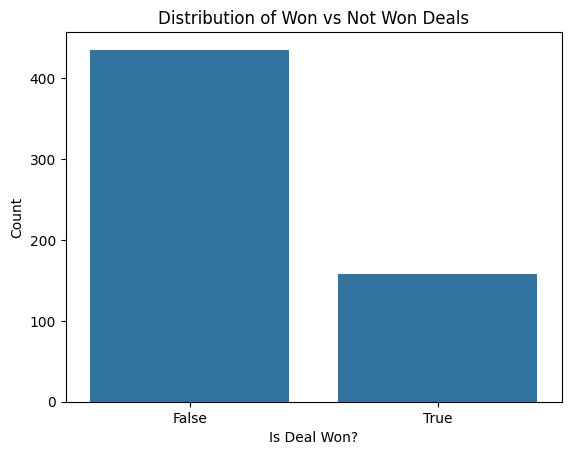

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the target variable
sns.countplot(data=df_clean, x='is_won')
plt.title("Distribution of Won vs Not Won Deals")
plt.xlabel("Is Deal Won?")
plt.ylabel("Count")
plt.show()


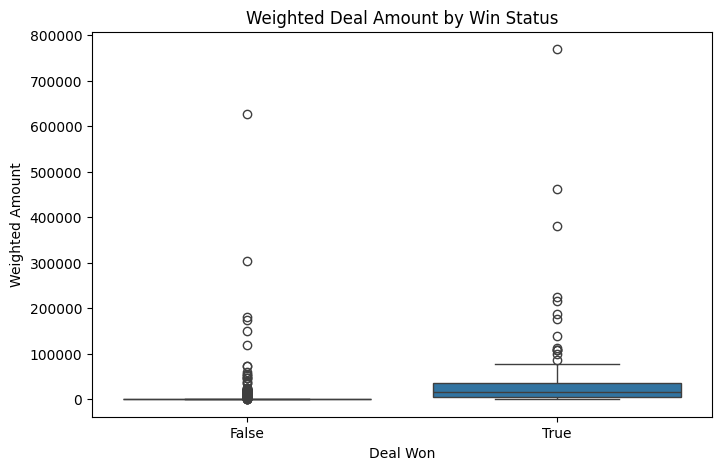

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x='is_won', y='weighted_amount', data=df_clean)
plt.title('Weighted Deal Amount by Win Status')
plt.xlabel('Deal Won')
plt.ylabel('Weighted Amount')
plt.show()


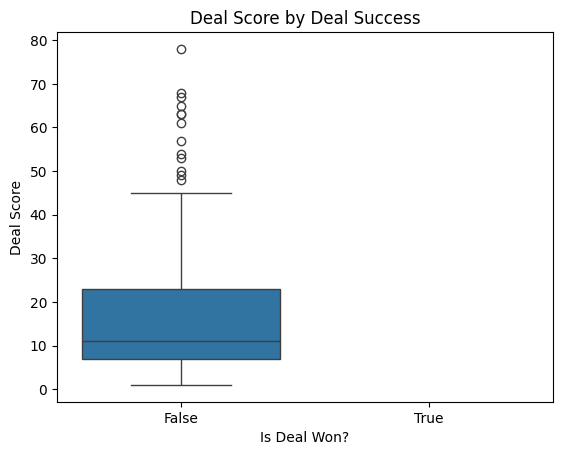

In [67]:
sns.boxplot(data=df_clean, x='is_won', y='deal_score')
plt.title("Deal Score by Deal Success")
plt.xlabel("Is Deal Won?")
plt.ylabel("Deal Score")
plt.show()


The deal score is only populated for deals that are not yet closed, meaning is_won=True deals always have a missing score. This suggests that deal scores are used primarily during the active pipeline stage and not retained after closure, making them a valuable predictive feature.

In [54]:
df_clean.groupby('is_won')['deal_score'].count()


is_won
False    167
True       0
Name: deal_score, dtype: int64

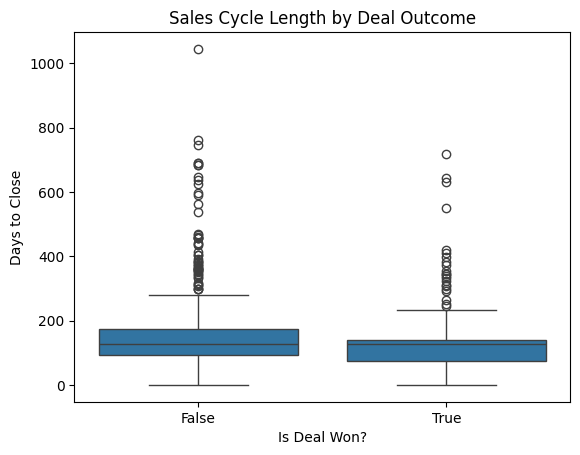

In [66]:
sns.boxplot(data=df_clean, x='is_won', y='days_to_close')
plt.title("Sales Cycle Length by Deal Outcome")
plt.xlabel("Is Deal Won?")
plt.ylabel("Days to Close")
plt.show()


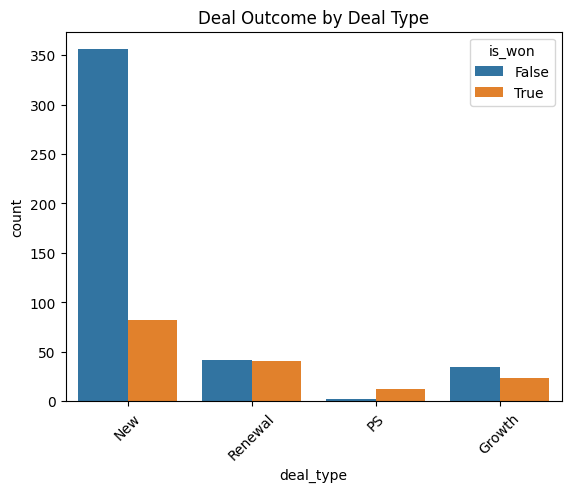

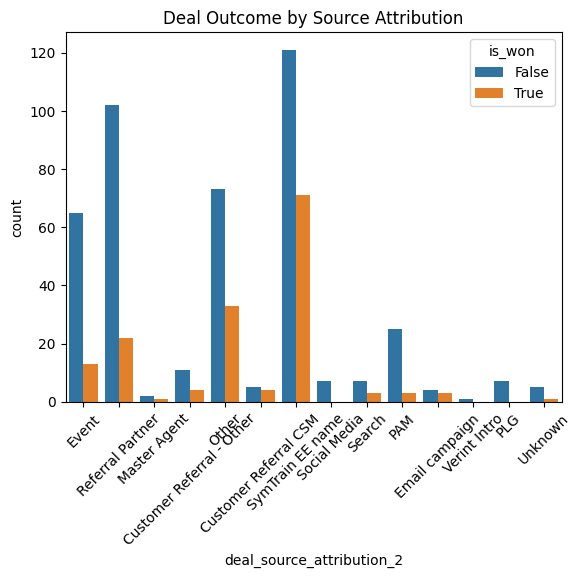

In [35]:
# Deal type vs is_won
sns.countplot(data=df_clean, x='deal_type', hue='is_won')
plt.title("Deal Outcome by Deal Type")
plt.xticks(rotation=45)
plt.show()

# Deal source vs is_won
sns.countplot(data=df_clean, x='deal_source_attribution_2', hue='is_won')
plt.title("Deal Outcome by Source Attribution")
plt.xticks(rotation=45)
plt.show()


1. Deal Outcome by Source Attribution
This bar chart breaks down the outcome (won vs. lost) of deals by their source. The source labeled “Customer Referral CSM” stands out as the most effective, with the highest number of won deals compared to other sources. “Events” also perform decently, though they have a high number of lost deals too. On the other hand, sources like “Referral Partner”, “Other”, and “Search” have a larger proportion of lost deals, making them less reliable. This suggests that personal or direct referrals tend to yield better deal outcomes.

2. Deal Outcome by Deal Type
This chart shows how different types of deals (e.g., New, Renewal, Growth) perform. The “New” deal type has the highest volume overall, but most of those deals are not won—indicating either poor qualification or a need to improve strategies for new deals. Interestingly, “Renewal” deals have nearly equal won and lost rates, which suggests a strong success rate and possible customer loyalty. “Growth” and “PS” (Professional Services?) deals have lower volume but still show a better win/loss ratio than New deals.



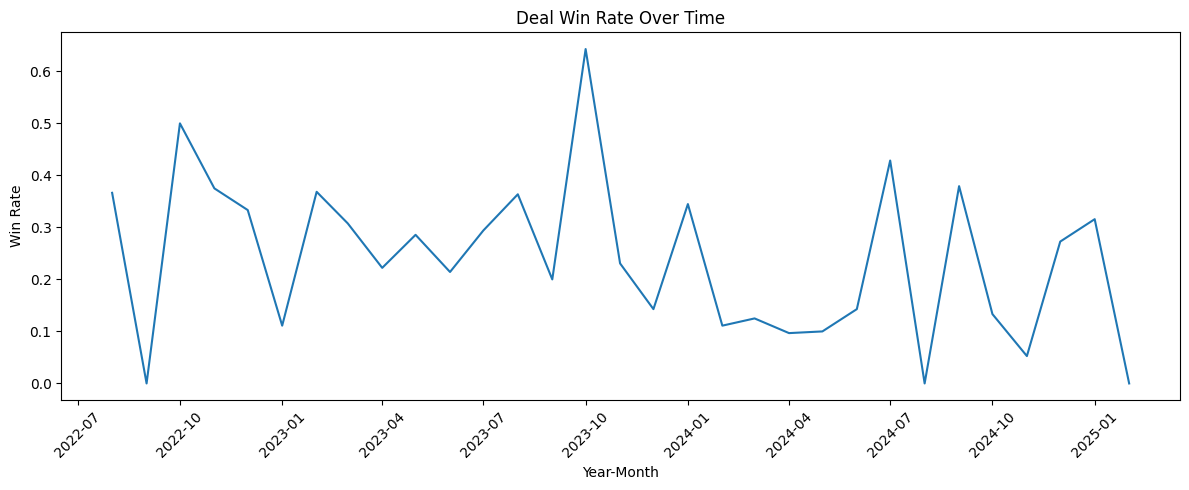

In [41]:
# Convert Period to timestamp
monthly_won['create_year_month'] = monthly_won['create_year_month'].dt.to_timestamp()

# Plot win rate over time
plt.figure(figsize=(12,5))
sns.lineplot(data=monthly_won, x='create_year_month', y='is_won')
plt.title("Deal Win Rate Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Win Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



This line chart tracks the monthly deal win rate, showing noticeable fluctuations over time. Some months—like October 2023—show a sharp spike, while others drop close to zero. This inconsistency could point to seasonal trends, campaign effects, or changes in lead quality or sales strategy. Understanding what caused the peaks and dips could help the sales team replicate success or avoid future slumps.

In [42]:
import numpy as np

def hhmmss_to_seconds(val):
    try:
        h, m, s = map(int, str(val).split(":"))
        return h * 3600 + m * 60 + s
    except:
        return np.nan

# Define the columns and their new names
duration_cols = {
    'cumulative_time_in_opportunity_sales_pipeline_hh:mm:ss': 'opportunity_stage_sec',
    'cumulative_time_in_in_trial_-_trial_in_progress_sales_pipeline_hh:mm:ss': 'in_trial_stage_sec',
    'cumulative_time_in_deep_dive._psp_drafted_sales_pipeline_hh:mm:ss': 'deep_dive_stage_sec',
    'cumulative_time_in_renewals__sales_pipeline_hh:mm:ss': 'renewals_stage_sec'
}

# Apply conversion
for col, new_col in duration_cols.items():
    if col in df_clean.columns:
        df_clean[new_col] = df_clean[col].apply(hhmmss_to_seconds)


In [49]:
import pandas as pd

# Convert time strings (HH:MM:SS) to seconds
def time_to_seconds(series):
    return pd.to_timedelta(series).dt.total_seconds()

# Create new columns for deep dive and renewals time in seconds
if 'time_deep_dive' in df_clean.columns:
    df_clean['secs_deep_dive'] = time_to_seconds(df_clean['time_deep_dive'])

if 'time_renewals' in df_clean.columns:
    df_clean['secs_renewals'] = time_to_seconds(df_clean['time_renewals'])

# Now calculate total pipeline time
time_stage_cols = ['secs_bant', 'secs_opportunity', 'secs_trial', 'secs_deep_dive', 'secs_renewals']
existing_cols = [col for col in time_stage_cols if col in df_clean.columns]

df_clean['total_pipeline_time_sec'] = df_clean[existing_cols].sum(axis=1, skipna=True)



In [44]:
df_clean['days_between_created_and_closed'] = (df_clean['close_date'] - df_clean['create_date']).dt.days


In [45]:
def score_bucket(score):
    if pd.isna(score):
        return 'Unknown'
    elif score < 20:
        return 'Low'
    elif score < 40:
        return 'Medium'
    else:
        return 'High'

if 'deal_score' in df_clean.columns:
    df_clean['deal_score_bucket'] = df_clean['deal_score'].apply(score_bucket)


In [46]:
df_clean['deal_notes_length'] = df_clean['deal_notes'].astype(str).str.len()


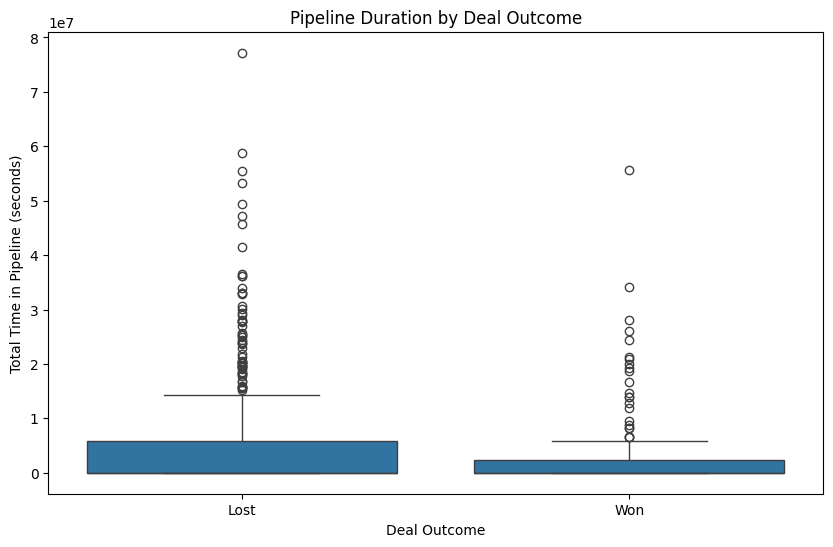

In [50]:
plt.figure(figsize=(10,6))
sns.boxplot(x='is_won', y='total_pipeline_time_sec', data=df_clean)
plt.title("Pipeline Duration by Deal Outcome")
plt.ylabel("Total Time in Pipeline (seconds)")
plt.xlabel("Deal Outcome")
plt.xticks([0,1], ['Lost', 'Won'])
plt.show()


This box plot shows that lost deals tend to spend more time in the sales pipeline compared to won deals. The distribution for lost deals has a longer tail and more extreme outliers, indicating that prolonged sales cycles might reduce the likelihood of success. This insight could help teams focus on reducing pipeline stagnation and identifying bottlenecks earlier in the process.



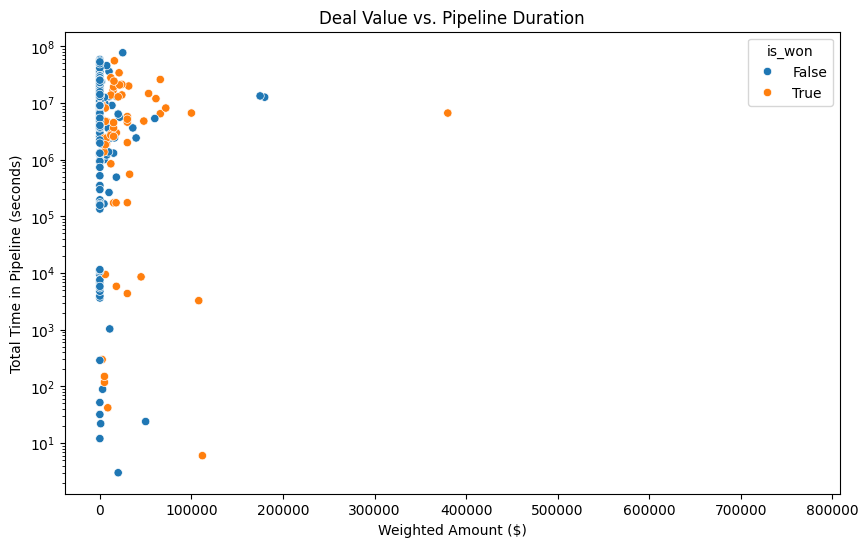

In [51]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_clean, x='weighted_amount', y='total_pipeline_time_sec', hue='is_won')
plt.title("Deal Value vs. Pipeline Duration")
plt.xlabel("Weighted Amount ($)")
plt.ylabel("Total Time in Pipeline (seconds)")
plt.yscale('log')  # use if there's a skew in time
plt.show()


This scatter plot reveals a weak correlation between deal value and time spent in the pipeline. Deals of all sizes can take both short and long durations, but interestingly, many high-value deals that were won (orange) show relatively reasonable time spans. This suggests that while larger deals don’t necessarily take longer, they may require focused pipeline management to avoid delays. The log scale helps highlight the variability in duration more clearly.

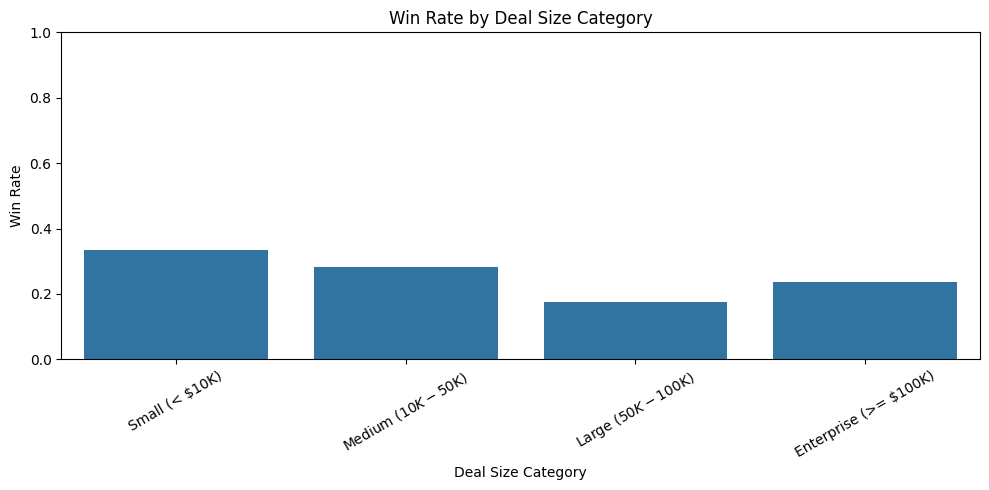

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(10, 5))

# Group by deal size and calculate win rate
deal_winrate_by_size = df_clean.groupby('deal_size_category')['is_won'].mean().reset_index()

# Sort the categories (optional)
size_order = ['Small (< $10K)', 'Medium ($10K-$50K)', 'Large ($50K-$100K)', 'Enterprise (>= $100K)']
deal_winrate_by_size['deal_size_category'] = pd.Categorical(deal_winrate_by_size['deal_size_category'], categories=size_order, ordered=True)
deal_winrate_by_size = deal_winrate_by_size.sort_values('deal_size_category')

# Plot
sns.barplot(data=deal_winrate_by_size, x='deal_size_category', y='is_won')
plt.title('Win Rate by Deal Size Category')
plt.xlabel('Deal Size Category')
plt.ylabel('Win Rate')
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


The bar chart shows that smaller deals (< $10K) have the highest win rate, followed by medium and enterprise deals. Large deals ($50K–$100K) have the lowest win rate. This suggests that while smaller deals are more likely to close, larger and enterprise deals are riskier but could yield more revenue per win. This trade-off highlights the importance of balancing deal volume with deal value in sales strategy.

